# This notebook talks about storage types

This tutorial will show you how to add a GPU to your node. There are currently two types of GPUs that you can add to your nodes on FABRIC

First, we need to prepare the environment. This is not the focus of this tutorial.

In [2]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

not_found=False
fabric_refresh_token=None
%store -r fabric_refresh_token

if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token
print("Fabric Refresh Token {}".format(fabric_refresh_token))
print("CILOGON_REFRESH_TOKEN environment variable: {}".format(os.environ['CILOGON_REFRESH_TOKEN']))

slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, 
                             refresh_token=fabric_refresh_token, project_name='all', scope='all')

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net
Fabric Refresh Token NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTSOJYGZRTIN3FGI4GKMJQGJSDINTBG5RTONBZME4GIMJUG4ZWGP3UPFYGKPLSMVTHEZLTNBKG623FNYTHI4Z5GE3DEMZVGM3DINJVHE2DIJTWMVZHG2LPNY6XMMROGATGY2LGMV2GS3LFHU4DMNBQGAYDAMA
CILOGON_REFRESH_TOKEN environment variable: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTEZJWGZRWENBRMU4GENJTGQ4DIMRYMI2WCODFMIYDQOLBGI2TCZR7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRTGQ2TKOBYHE2TIOBGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ


In [3]:
try:
    id_token, refresh_token = slice_manager.refresh_tokens()
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

fabric_refresh_token=slice_manager.get_refresh_token()
print()
print("New Refresh Token: {}".format(fabric_refresh_token))
print()
print("Stored new Refresh Token")
%store fabric_refresh_token
print()
print()


New Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTEYLDGMYTCYZRHE3TAMRRGI2DOM3DGZSDSM3DMY4WKMBVGAYDMNR7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRTGUZTSNBXGQ4TANRGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ

Stored new Refresh Token
Stored 'fabric_refresh_token' (str)




### Tutorial starts here.

First, we can query for available resources:

In [4]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: UKY: { cpu: 6/6 , core: 96/96 , ram: 1,536/1,536 G, disk: 109,600/109,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 12/12 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
Links:


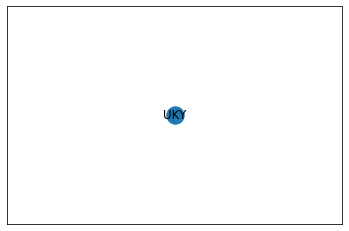

In [5]:
if status == Status.OK:
    advertised_topology.draw()

The cell below creates a slice that contains one node.

The node has two GPUs attached to it, which are an `RTX6000` and a `Tesla T4`. This is done through those two lines of code:

`n1.add_component(ctype=ComponentType.GPU, model='RTX6000', name='gpu1')`

`n1.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='gpu2')`

You can use these lines of code to add GPUs to your nodes.

More details about the RTX6000 GPU: "NVIDIA Corporation TU102GL [Quadro RTX 6000/8000] (rev a1)".

More details about the Tesla T4 GPU: "NVIDIA Corporation TU104GL [Tesla T4] (rev a1)"

In [18]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='UKY')

# Set capacities
cap = Capacities()
cap.set_fields(core=4, ram=4, disk=500)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.GPU, model='RTX6000', name='gpu1')

# Add PCI devices
n1.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='gpu2')

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='JupyterSlice1', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
print("Reservations created {}".format(reservations))

Response Status Status.OK
Reservations created [{
    "graph_node_id": "5232083c-70d1-4176-849c-bdae733a887f",
    "join_state": "None_",
    "lease_end": "2021-06-13 23:13:01",
    "reservation_id": "a68f94fe-14ab-4b2a-a957-a821f245aa11",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "fec0f97a-c923-4c05-a110-f6b9420e3c58"
}]


## Below are some status commands. This is not the focus of this tutorial.

In [19]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [20]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))

Response Status Status.OK
Slices []


## Query Slice

In [21]:
status, slice_obj = slice_manager.get_slice(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Response received {}".format(slice_obj))

Response Status Status.OK
Response received n1[VM]:  { core: 4 , ram: 4 G, disk: 500 G}
Links:


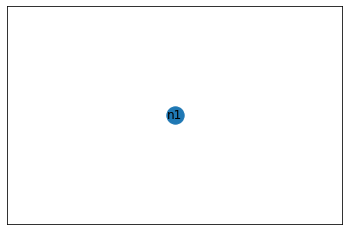

In [64]:
slice_obj.draw()

## Query Slivers

In [17]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))

Response Status Status.OK
Slivers [{
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c4.m16.d500\"}",
    "graph_node_id": "0bce2f74-9192-4132-a3ce-777923713489",
    "join_state": "NoJoin",
    "lease_end": "2021-06-13 23:12:09",
    "name": "n1t",
    "reservation_id": "70584029-d86d-4f55-9a19-484e4f014aac",
    "reservation_state": "Closed",
    "resource_type": "VM",
    "site": "UKY",
    "slice_id": "a6266fa6-3a19-4ccc-ab69-b32e4f8b3d3c"
}]
